In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.3 MB 16.6 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 13.8 MB/s eta 0:00:01
   ----------------------------

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


###LOGREG


In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load your training dataset
df_higgs = pd.read_csv("/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/covtype_train.csv")
#df_higgs = df_higgs['Label'].replace(('b','s'), (0,1))
#df_higgs['Label'] = df_higgs['Label'].replace({'b': 0, 's': 1})
#df_higgs['RiskPerformance'] = df_higgs['RiskPerformance'].replace(('Bad', 'Good'), (0, 1))

# Load your test dataset
higgs_test = pd.read_csv("/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/covtype_test.csv")  # adjust path as necessary
test_submission = pd.read_csv("/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/covtype_test_submission.csv")  # adjust path as necessary
# Separate features and target variable in training data
X_train = df_higgs.drop('Cover_Type', axis=1)  # Replace 'label' with the actual name of your target column
y_train = df_higgs['Cover_Type']


# SMOTE balancing on CoverType Dataset
from imblearn.over_sampling import SMOTE
from collections import Counter
counter = Counter(y_train)
#print('Before', counter)
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)
counter = Counter(y_train)
#print('After', counter)

# Prepare test data (assuming higgs_test has the same features as df_higgs)
X_test = higgs_test  # If higgs_test has no label column, just use higgs_test

# Create a pipeline with StandardScaler and LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Define the parameter grid to search
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['liblinear', 'saga']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=KFold(n_splits=5),
    verbose=1
)

# Fit the model on training data
grid_search.fit(x_train_smt, y_train_smt)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Predict on test data with the best model
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)

# Assuming 'EventId' is a column in higgs_test
test_results_df = pd.DataFrame({
    #'EventId': higgs_test['EventId'],
    'Predictions': test_predictions
})

# Assuming the best model is found and is named 'best_model'
y_pred = best_model.predict(X_test)

# Add predictions to test_submission DataFrame
test_submission['pred'] = y_pred

# Drop the original 'Prediction' column and rename 'pred' to 'Prediction'
test_submission = test_submission.drop('Prediction', axis=1)
test_submission = test_submission.rename(columns={'pred': 'Prediction'})

# Save the updated DataFrame to CSV
test_submission.to_csv('covtype_logreg_results.csv', index=False)

print(f'Test data predictions saved to logreg_results.csv')



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/covtype_train.csv'

### LIGHT GBM

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Load your training dataset
df_higgs = pd.read_csv("/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/covtype_train.csv")
#df_higgs = df_higgs['Label'].replace(('b','s'), (0,1))
#df_higgs['Label'] = df_higgs['Label'].replace({'b': 0, 's': 1})
#df_higgs['RiskPerformance'] = df_higgs['RiskPerformance'].replace(('Bad', 'Good'), (0, 1))

# Load your test dataset
higgs_test = pd.read_csv("/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/covtype_test.csv")  # adjust path as necessary
test_submission = pd.read_csv("/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /benchmark-tabular-ml/covtype_test_submission.csv")  # adjust path as necessary
# Separate features and target variable in training data
X_train = df_higgs.drop('Cover_Type', axis=1)  # Replace 'label' with the actual name of your target column
y_train = df_higgs['Cover_Type']

#SMOTE on CoverType with LightGBM
counter = Counter(y_train)
#print('Before', counter)

smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)
counter = Counter(y_train)

# Prepare test data (assuming higgs_test has the same features as df_higgs)
X_test = higgs_test  # If higgs_test has no label column, just use higgs_test



# Initialize LightGBM classifier
clf = lgb.LGBMClassifier()

# Define hyperparameters grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500]
}

# Create GridSearchCV object
grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=2, verbose=1)

# Perform hyperparameter tuning
grid.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid.best_params_)
print("Best cross-validation score: {:.4f}".format(grid.best_score_))

# Make predictions on the test set with the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Add predictions to test_submission DataFrame
test_submission['pred'] = y_pred

# Drop the original 'Prediction' column and rename 'pred' to 'Prediction'
test_submission = test_submission.drop('Prediction', axis=1)
test_submission = test_submission.rename(columns={'pred': 'Prediction'})

# Save the updated DataFrame to CSV
test_submission.to_csv(path + 'covtype_lightgbm.csv', index=False)

print("Test data predictions saved to higgs_predictions.csv")

Streaminguitvoer ingekort tot de laatste 5000 regels.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

NameError: ignored

## Higgs EDA

In [ ]:
# drop EventId column -> just some Id we dont need
higgs = df_higgs.drop(['EventId'], axis=1)

In [ ]:
# possibly problematic columns
higg_columns_problem = ['DER_mass_MMC',
'DER_deltaeta_jet_jet',
'DER_mass_jet_jet',
'DER_prodeta_jet_jet',
'DER_lep_eta_centrality',
'DER_met_phi_centrality',
'PRI_jet_leading_pt',
'PRI_jet_leading_eta',
'PRI_jet_num',
'PRI_jet_leading_phi',
'PRI_jet_subleading_pt',
'PRI_jet_subleading_eta',
'PRI_jet_subleading_phi',
'PRI_jet_all_pt',
'Weight']

In [ ]:
# function to test how "balanced" these features are in terms of label distribution over them
# because these columns have different scales, use median to "divide" values
def test_balancedness(data, columns):
  for column in columns:
    selection = df_higgs[[column, 'Label']].copy()
    print(column)
    print(selection[selection[column] >= selection[column].median()].groupby('Label').size())

In [ ]:
# identified coluns imbalanced (no hard criteria, just eye measure)
imbalanced_columns = ['DER_deltaeta_jet_jet',
'DER_mass_jet_jet',
'DER_prodeta_jet_jet',
'DER_lep_eta_centrality',
'PRI_jet_subleading_pt',
'PRI_jet_subleading_eta',
'PRI_jet_subleading_phi',
'Weight']

In [ ]:
#drop
higgs = higgs.drop(imbalanced_columns, axis=1)

In [ ]:
# PRI_jet_num is int, check distribution over labels
df_higgs.groupby('PRI_jet_num')['Label'].size()

PRI_jet_num
0    69904
1    54243
2    35399
3    15454
Name: Label, dtype: int64

In [ ]:
# possibly imbalanced, so drop it for now
higgs = higgs.drop('PRI_jet_num', axis=1)

<ipython-input-87-6b23d5630011>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = higgs.corr()
<ipython-input-87-6b23d5630011>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<Axes: >

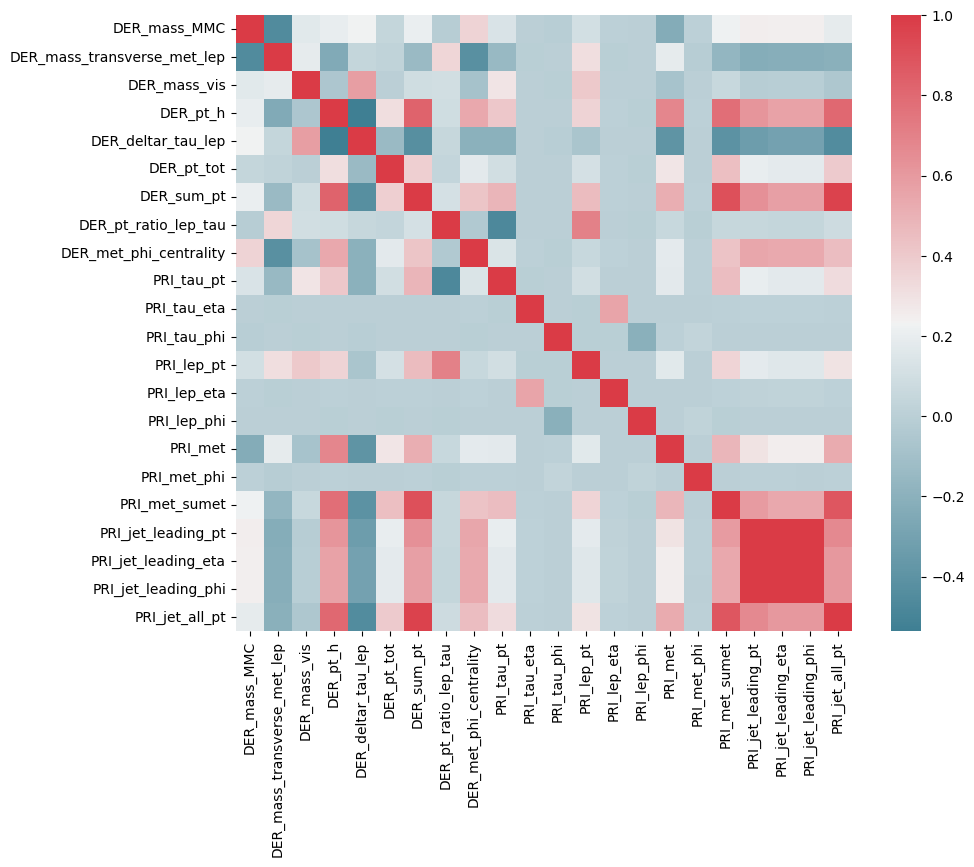

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = higgs.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
# all the PRI columsn have a high correlation
coll_columns1 = ['PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_all_pt']

In [ ]:
higgs = higgs.drop(coll_columns1, axis=1)

<ipython-input-90-0ae367f9c52a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = higgs.corr()
<ipython-input-90-0ae367f9c52a>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<Axes: >

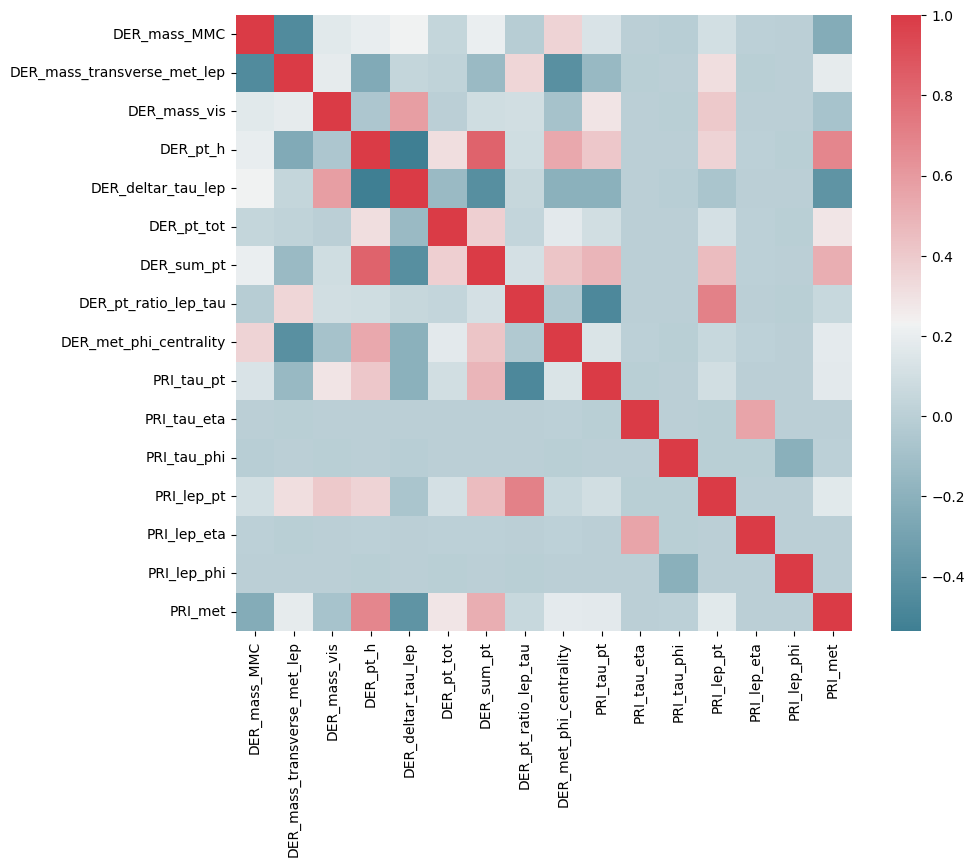

In [ ]:
#check again
f, ax = plt.subplots(figsize=(10, 8))
corr = higgs.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

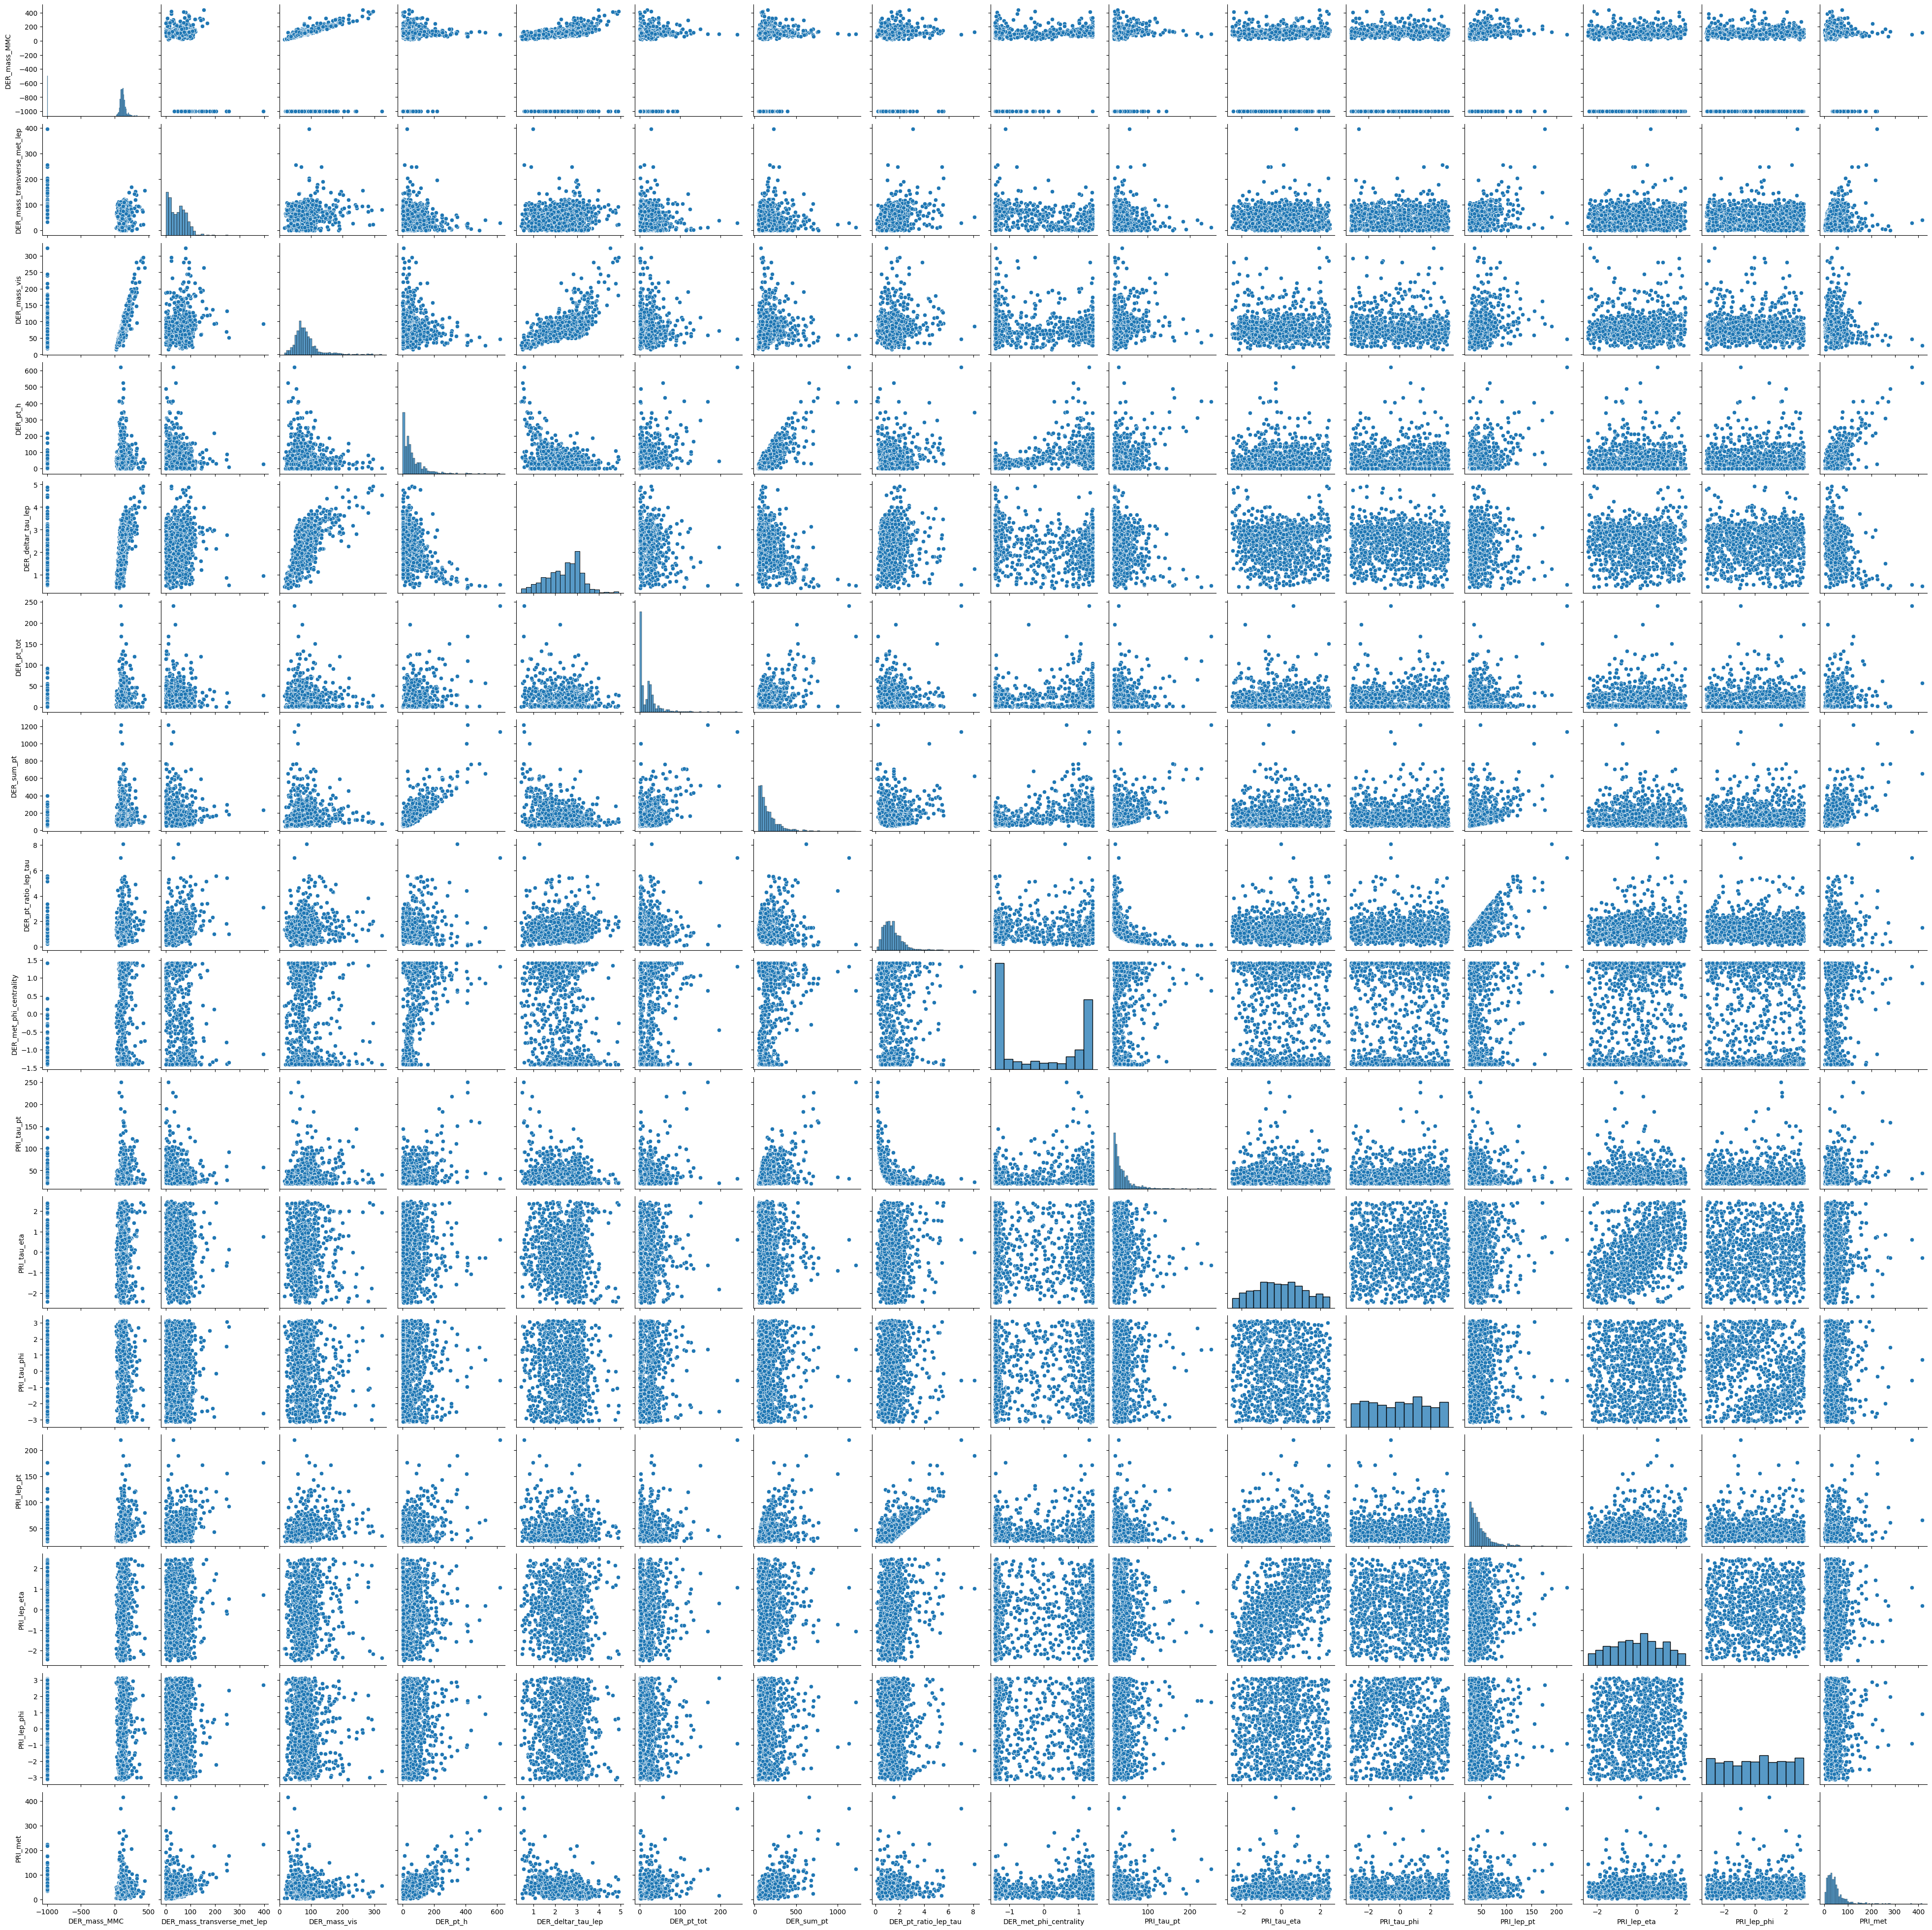

In [ ]:
# check for other non-linear relationships between features
# take sample, otherwise too big to plot
higgs_sample = higgs.sample(1000, random_state=42)
sns.pairplot(higgs_sample)

In [ ]:
# final list of columns to drop
higgs_drop = ['EventId',
              'DER_deltaeta_jet_jet',
              'DER_mass_jet_jet',
              'DER_prodeta_jet_jet',
              'DER_lep_eta_centrality',
              'PRI_jet_subleading_pt',
              'PRI_jet_subleading_eta',
              'PRI_jet_subleading_phi',
              'Weight',
              'PRI_jet_num',
              'PRI_met_phi',
              'PRI_met_sumet',
              'PRI_jet_leading_pt',
              'PRI_jet_leading_eta',
              'PRI_jet_leading_phi',
              'PRI_jet_all_pt']

### Prepare Datasets

In [ ]:
def clean_higgs_data(data, drop_columns, train=True):
  print("Inital dimensions:", data.values.shape)
  if train:
    # replace labels with int values (because final submission needs to be 0, 1)
    data['Label'] = data['Label'].replace(('b','s'), (0,1))
  #drop columns
  data = data.drop(drop_columns, axis=1)
  print("New dimensions:", data.values.shape)
  return data

In [ ]:
clean_higgs_data(df_higgs, higgs_drop)

Inital dimensions: (175000, 33)
New dimensions: (175000, 17)


DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0            136.372                       32.142        95.158    24.012   
1            123.147                       73.967        73.065     1.951   
2            114.196                       77.282        84.580     1.398   
3            113.938                       37.713        78.068    73.541   
4           -999.000                       82.024        55.707    15.350   
...              ...                          ...           ...       ...   
174995       121.911                       56.518        65.629    46.272   
174996      -999.000                       65.925        78.781     3.387   
174997       134.949                       43.702        97.972    28.240   
174998       126.725                       23.997        87.432   283.336   
174999        79.885                       58.412        56.758    14.061   

        DER_deltar_tau_lep  DER_pt_tot  DER_sum_pt  DER_pt_ratio_lep_tau  \
0                    2.650      24.012      81.013                 0.499   
1                    3.181       1.951      73.968                 2.106   
2                    2.808       1.398      86.994                 1.752   
3                    2.062       2.179     176.908                 0.670   
4                    1.943      15.350      62.787                 1.461   
...                    ...         ...         ...                   ...   
174995               3.068       6.385      98.652                 0.821   
174996               2.493       3.387      55.956                 1.038   
174997               3.443      28.240      77.985                 0.703   
174998               0.872     107.851     621.442                 0.367   
174999               2.512      16.746     276.699                 1.144   

        DER_met_phi_centrality  PRI_tau_pt  PRI_tau_eta  PRI_tau_phi  \
0                       -0.976      54.044       -0.030       -1.466   
1                        1.064      23.812        1.477       -2.197   
2                       -1.354      31.613        0.032       -1.295   
3                        1.380      55.592       -1.102       -1.189   
4                       -1.414      25.509       -1.108        2.158   
...                        ...         ...          ...          ...   
174995                   1.404      32.261       -0.537        0.664   
174996                  -1.409      27.453       -0.378        1.416   
174997                  -1.414      45.793       -0.564        1.563   
174998                   1.399     170.813        0.852        0.785   
174999                  -1.398      27.652        1.917       -0.964   

        PRI_lep_pt  PRI_lep_eta  PRI_lep_phi  PRI_met  Label  
0           26.969       -1.637        0.641   40.636      0  
1           50.156        0.805        0.977   27.279      0  
2           55.381        0.498        2.219   27.909      0  
3           37.219       -1.132        0.873   23.319      1  
4           37.278       -0.121       -2.452   54.284      0  
...            ...          ...          ...      ...    ...  
174995      26.489        0.468       -2.720   37.187      1  
174996      28.503        1.739        2.731   41.678      0  
174997      32.192       -2.016       -1.599   16.124      1  
174998      62.739        0.817        1.656   68.778      1  
174999      31.622        1.624        1.531   32.000      0  

[175000 rows x 17 columns]

In [ ]:
df_higgs_test = pd.read_csv("/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /05. Applied Machine Learning /higgs_test.csv")

In [ ]:
#clean_training_data = clean_higgs_data(df_higgs, higgs_drop)
training_data = clean_higgs_data(df_higgs, higgs_drop)
test_data = df_higgs_test.drop(higgs_drop, axis=1)

Inital dimensions: (175000, 33)
New dimensions: (175000, 17)


DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0            136.372                       32.142        95.158    24.012   
1            123.147                       73.967        73.065     1.951   
2            114.196                       77.282        84.580     1.398   
3            113.938                       37.713        78.068    73.541   
4           -999.000                       82.024        55.707    15.350   
...              ...                          ...           ...       ...   
174995       121.911                       56.518        65.629    46.272   
174996      -999.000                       65.925        78.781     3.387   
174997       134.949                       43.702        97.972    28.240   
174998       126.725                       23.997        87.432   283.336   
174999        79.885                       58.412        56.758    14.061   

        DER_deltar_tau_lep  DER_pt_tot  DER_sum_pt  DER_pt_ratio_lep_tau  \
0                    2.650      24.012      81.013                 0.499   
1                    3.181       1.951      73.968                 2.106   
2                    2.808       1.398      86.994                 1.752   
3                    2.062       2.179     176.908                 0.670   
4                    1.943      15.350      62.787                 1.461   
...                    ...         ...         ...                   ...   
174995               3.068       6.385      98.652                 0.821   
174996               2.493       3.387      55.956                 1.038   
174997               3.443      28.240      77.985                 0.703   
174998               0.872     107.851     621.442                 0.367   
174999               2.512      16.746     276.699                 1.144   

        DER_met_phi_centrality  PRI_tau_pt  PRI_tau_eta  PRI_tau_phi  \
0                       -0.976      54.044       -0.030       -1.466   
1                        1.064      23.812        1.477       -2.197   
2                       -1.354      31.613        0.032       -1.295   
3                        1.380      55.592       -1.102       -1.189   
4                       -1.414      25.509       -1.108        2.158   
...                        ...         ...          ...          ...   
174995                   1.404      32.261       -0.537        0.664   
174996                  -1.409      27.453       -0.378        1.416   
174997                  -1.414      45.793       -0.564        1.563   
174998                   1.399     170.813        0.852        0.785   
174999                  -1.398      27.652        1.917       -0.964   

        PRI_lep_pt  PRI_lep_eta  PRI_lep_phi  PRI_met  Label  
0           26.969       -1.637        0.641   40.636      0  
1           50.156        0.805        0.977   27.279      0  
2           55.381        0.498        2.219   27.909      0  
3           37.219       -1.132        0.873   23.319      1  
4           37.278       -0.121       -2.452   54.284      0  
...            ...          ...          ...      ...    ...  
174995      26.489        0.468       -2.720   37.187      1  
174996      28.503        1.739        2.731   41.678      0  
174997      32.192       -2.016       -1.599   16.124      1  
174998      62.739        0.817        1.656   68.778      1  
174999      31.622        1.624        1.531   32.000      0  

[175000 rows x 17 columns]

## PCA check

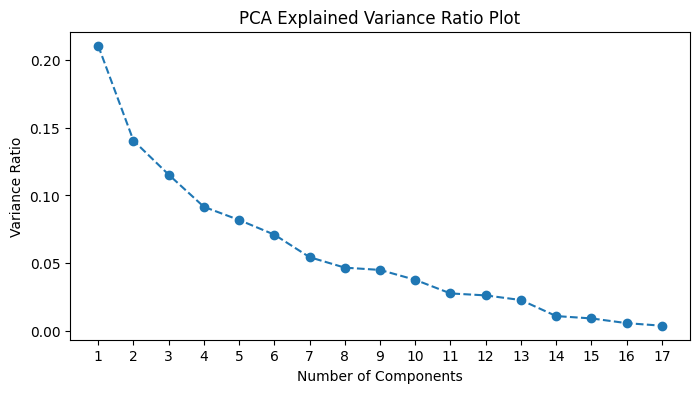

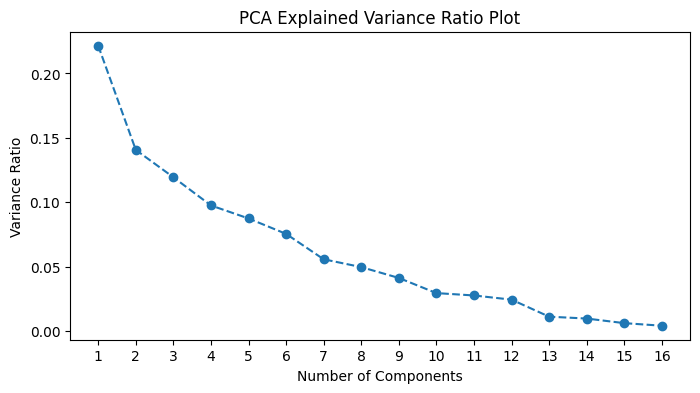

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define the function
def perform_pca_and_plot(data):
    # Standardizing the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Performing PCA without reducing dimensionality to retain all components
    pca = PCA()
    pca.fit(data_scaled)

    # Calculating the explained variance ratio for each component
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plotting the Scree Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
    plt.title('PCA Explained Variance Ratio Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Ratio')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.show()

# Call the function on training and test data
perform_pca_and_plot(training_data)
perform_pca_and_plot(test_data)


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the function to perform PCA
def perform_pca(data, n_components=10):
    # Standardizing the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Performing PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)

    # Creating a DataFrame with principal components
    column_names = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(data=principal_components, columns=column_names)

    # Examining the explained variance
    explained_variance = pca.explained_variance_ratio_
    total_explained_variance = explained_variance.sum()  # Summing the explained variance

    print("Explained Variance per Component: ", explained_variance)
    print("Total Explained Variance: ", total_explained_variance)
    print(pca_df.head())

    return pca_df

#drop dependent variable for training data
#label_train = training_data['Label']
#training_data = training_data.drop('Label', axis=1)

# Assuming 'data' is your training dataset and 'higgs_test' is your test dataset
#training_data = data.drop('label_bin', axis=1)  # Dropping the 'label_bin' column
#test_data = higgs_test  # Replace 'higgs_test' with your actual test data DataFrame

# Call the function and store the results
training_data_PCA = perform_pca(training_data, n_components=10)
test_data_PCA = perform_pca(test_data, n_components=10)

Explained Variance per Component:  [0.22016282 0.1409797  0.11962308 0.09728022 0.08692011 0.07544286
 0.0563781  0.04953079 0.04087062 0.02928229]
Total Explained Variance:  0.916470568189055
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.846043 -1.235568 -0.410343  0.986962  1.055657 -0.782442  0.472896   
1 -1.272935  0.543430 -0.700612 -1.406059 -1.036513 -1.212775 -0.170769   
2 -1.598136  0.917463 -0.332277 -0.327155  0.046460 -1.340934 -0.529453   
3  0.495907 -1.485987 -0.465308  1.288839  0.033460 -0.792199 -0.791616   
4 -1.393966  0.776552  2.589026  0.654745  0.631931  1.780215 -0.004504   

        PC8       PC9      PC10  
0 -0.322197 -0.165126  0.599054  
1 -0.483730  0.744722 -0.743171  
2  0.335909 -0.275321  0.523489  
3 -0.160788  0.158146 -0.910649  
4 -0.157161  0.136255 -0.321862  
Explained Variance per Component:  [0.22148597 0.14058145 0.11934396 0.09745461 0.08734868 0.07537879
 0.05564549 0.04958015 0.04114439 0.02938795]
Tota

### Evaluating Neural Networks


Neural Network on non-PCA data and no Kfoldcross validation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# Assuming 'training_data_PCA' is your PCA-transformed training dataset and 'label_train' are the corresponding labels
# 'test_data_PCA' is your PCA-transformed test dataset without labels

# Convert features and labels to PyTorch tensors for training data
X_train = torch.tensor(training_data.drop('Label', axis=1).values, dtype=torch.float32)
Y_train = torch.tensor(training_data['Label'].values, dtype=torch.float32)
X_test = torch.tensor(test_data_PCA.values, dtype=torch.float32)  # Test data


# Define a neural network model
class HiggsClassifier(nn.Module):
    def __init__(self, input_size):
        super(HiggsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Create an instance of the model
input_size = X_train.shape[1]
model = HiggsClassifier(input_size)

# Define a loss function and an optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Print the training loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item()}')

# Making predictions on test data
model.eval()
test_predictions = []
with torch.no_grad():
    for inputs in DataLoader(X_test, batch_size=64):
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        test_predictions.extend(predicted.numpy())

# Convert to DataFrame and save to CSV
test_predictions_df = pd.DataFrame(test_predictions, columns=['Predictions'])
test_predictions_df.to_csv('test_data_results_noPCA&Kfold.csv', index=False)

print(f'Test data predictions saved to test_data_results.csv')


Epoch [1/10] Loss: 0.35670503973960876
Epoch [2/10] Loss: 0.43156954646110535
Epoch [3/10] Loss: 0.299137145280838
Epoch [4/10] Loss: 0.3776552379131317
Epoch [5/10] Loss: 0.400726318359375
Epoch [6/10] Loss: 0.5327373147010803
Epoch [7/10] Loss: 0.3531569540500641
Epoch [8/10] Loss: 0.43854132294654846
Epoch [9/10] Loss: 0.3998003900051117
Epoch [10/10] Loss: 0.297696977853775


RuntimeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

# Define the neural network model
class HiggsClassifier(nn.Module):
    def __init__(self, input_size):
        super(HiggsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

# Function for k-fold cross-validation
def kfold_cross_validation(X, Y, k=5, num_epochs=10):
    kfold = KFold(n_splits=k, shuffle=True)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)):
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Split data
        X_train_fold, X_test_fold = X[train_ids], X[test_ids]
        Y_train_fold, Y_test_fold = Y[train_ids], Y[test_ids]

        # Convert to tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        Y_train_fold = torch.tensor(Y_train_fold, dtype=torch.float32)
        X_test_fold = torch.tensor(X_test_fold, dtype=torch.float32)
        Y_test_fold = torch.tensor(Y_test_fold, dtype=torch.float32)

        # Create data loaders
        train_dataset = TensorDataset(X_train_fold, Y_train_fold)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        # Initialize model
        model = HiggsClassifier(input_size=X.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_model(model, train_loader, criterion, optimizer, num_epochs)

        # Evaluation for this fold
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in DataLoader(TensorDataset(X_test_fold, Y_test_fold), batch_size=64):
                outputs = model(inputs)
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.unsqueeze(1)).sum().item()

        accuracy = correct / total
        print(f'Fold {fold} Accuracy: {100 * accuracy:.2f}%')

# Load your training data
# Assuming 'training_data_PCA' is your PCA-transformed training dataset and 'label_train' are the corresponding labels
X = torch.tensor(training_data_PCA.values, dtype=torch.float32)
Y = torch.tensor(label_train.values, dtype=torch.float32)

#torch.tensor(test_data_PCA.values, dtype=torch.float32)

# Perform k-fold cross-validation
kfold_cross_validation(X, Y, k=5, num_epochs=10)

# Train final model on entire dataset
final_model = HiggsClassifier(input_size=X.shape[1])
final_criterion = nn.BCELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=0.001)
final_train_loader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)), batch_size=64, shuffle=True)
train_model(final_model, final_train_loader, final_criterion, final_optimizer, num_epochs=10)

# Making predictions on test data
# Assuming 'test_data_PCA' is your PCA-transformed test dataset without labels
X_test = torch.tensor(test_data_PCA.values, dtype=torch.float32)  # Test data

final_model.eval()
test_predictions = []
with torch.no_grad():
    for inputs in DataLoader(X_test, batch_size=64):
        outputs = final_model(inputs)
        predicted = (outputs >= 0.5).float()
        test_predictions.extend(predicted.numpy())

# Convert to DataFrame and save to CSV
test_predictions_df = pd.DataFrame(test_predictions, columns=['Predictions'])
test_predictions_df.to_csv('test_data_results.csv', index=False)

print(f'Test data predictions saved to test_data_results.csv')



FOLD 0
--------------------------------


<ipython-input-77-645f206d5140>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
<ipython-input-77-645f206d5140>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_fold = torch.tensor(Y_train_fold, dtype=torch.float32)
<ipython-input-77-645f206d5140>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_fold = torch.tensor(X_test_fold, dtype=torch.float32)
<ipython-input-77-645f206d5140>:53: UserWarning: To copy construct from a tensor, it is recommended to use sour

Fold 0 Accuracy: 82.71%
FOLD 1
--------------------------------


<ipython-input-77-645f206d5140>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
<ipython-input-77-645f206d5140>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_fold = torch.tensor(Y_train_fold, dtype=torch.float32)
<ipython-input-77-645f206d5140>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_fold = torch.tensor(X_test_fold, dtype=torch.float32)
<ipython-input-77-645f206d5140>:53: UserWarning: To copy construct from a tensor, it is recommended to use sour

Fold 1 Accuracy: 82.56%
FOLD 2
--------------------------------
Fold 2 Accuracy: 82.58%
FOLD 3
--------------------------------
Fold 3 Accuracy: 82.77%
FOLD 4
--------------------------------
Fold 4 Accuracy: 82.30%


<ipython-input-77-645f206d5140>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_train_loader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)), batch_size=64, shuffle=True)


Test data predictions saved to test_data_results.csv
